### A quick demonstration of cosmic birefringence reconstruction in fullsky
### - this code shows how to compute the estiamtors, and output their power spectra

In [1]:
# load modules
import numpy as np
import basic
import curvedsky
import cmb
from matplotlib.pyplot import *

Define parameters

In [2]:
Tcmb  = 2.726e6    # CMB temperature
lmax  = 2048       # maximum multipole of output normalization
rlmin = 100
rlmax = 2048      # reconstruction multipole range
sig   = 10.
Acb   = 1e-5 # signal
ac2rad = np.pi/180./60.
L = np.linspace(0,lmax,lmax+1)
nside = 2048

Load unlensed and lensed Cls

In [3]:
lcl = cmb.read_camb_cls('../data/lensedcls.dat',ftype='lens',output='array')[:,:lmax+1]
nl  = np.zeros((4,lmax+1))
nl[0,:] = (sig*ac2rad/Tcmb)**2
nl[1,:] = 2*nl[0,:]
nl[2,:] = 2*nl[0,:]
ocl = lcl + nl

Calculate normalizations

In [4]:
Al = np.zeros((2,lmax+1))
Al[0,:] = curvedsky.norm_quad.qeb('rot',lmax,rlmin,rlmax,lcl[1,:rlmax+1],ocl[1,:rlmax+1],ocl[2,:rlmax+1])[0]
Al[1,:] = curvedsky.norm_quad.qtb('rot',lmax,rlmin,rlmax,lcl[3,:rlmax+1],ocl[0,:rlmax+1],ocl[2,:rlmax+1])[0]

Simple diagonal c-inverse

In [5]:
Fl = np.zeros((3,lmax+1,lmax+1))
for l in range(rlmin,rlmax):
    Fl[:,l,0:l+1] = 1./ocl[:3,l,None]

Generate CMB alms \
Gaussian alms are generated, and the reconstructed cls are equal to the normalization

In [6]:
__, Ealm, Balm = curvedsky.utils.gaussTEB(lmax,lcl[0,:],lcl[1,:],lcl[2,:],lcl[3,:])
Ealm += curvedsky.utils.gauss1alm(lmax,nl[1,:])
Balm += curvedsky.utils.gauss1alm(lmax,nl[2,:])
Q, U = curvedsky.utils.hp_alm2map_spin(nside,lmax,lmax,2,Ealm,Balm)

In [7]:
claa = Acb*2*np.pi/(L**2+L+1e-30)
aalm = curvedsky.utils.gauss1alm(lmax,claa)
alpha = curvedsky.utils.hp_alm2map(nside,lmax,lmax,aalm)

In [8]:
rQ = Q*np.cos(2.*alpha) - U*np.sin(2.*alpha)
rU = Q*np.sin(2.*alpha) + U*np.cos(2.*alpha)
Ealm, Balm = curvedsky.utils.hp_map2alm_spin(nside,lmax,lmax,2,rQ,rU)

Diagonal filtering

In [9]:
Ealm *= Fl[1,:,:]
Balm *= Fl[2,:,:]

Compute unnormalized estiamtors

In [10]:
alm = curvedsky.rec_rot.qeb(lmax,rlmin,rlmax,lcl[1,:],Ealm,Balm)

Normalized estimators

In [11]:
alm *= Al[0][:,None]

Compute power spectrum

In [12]:
cl = curvedsky.utils.alm2cl(lmax,alm,aalm)

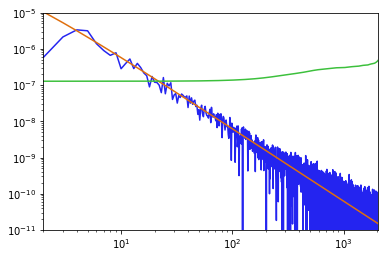

In [13]:
xscale('log')
yscale('log')
xlim(2,lmax)
ylim(1e-11,1e-5)
plot(L,cl)
plot(L,claa)
plot(Al[0])